# AI Generated Image Detection - Project Report - Group 10

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

### PRESETTINGS
The settings here allow you to choose which experiment to perform. The default and final result is (1).  
(1): model_name = 'resnet', enhancement = True, use_focal = True  
(2): model_name = 'resnet', enhancement = False, use_focal = False  
(3): model_name = 'vit', enhancement = False, use_focal = False  
(4): model_name = 'swin', enhancement = False, use_focal = False  
(5): model_name = 'resnet', enhancement = True, use_focal = False

In [2]:
model_name = 'resnet' #'resnet', 'swin' or 'vit'
enhancement = True
use_focal = True

### 1 INTRODUCTION
The ability to create convincing, photorealistic images has advanced significantly in recent years, largely due to breakthroughs in Generative Adversarial Networks (GANs) and diffusion models. These deep learning techniques have substantially improved the realism of AI-generated content, making it increasingly difficult to differentiate between real and synthetic images. While these advances have valuable applications in entertainment and art, they also pose serious concerns regarding misinformation, privacy, and security. The potential for weaponizing AI-generated content has led to growing interest in detecting such images.

Detecting AI-generated content (AIGC) has become a critical challenge in both research and practical applications. As these generative models become more sophisticated, traditional detection methods are no longer sufficient. In this project, we focus on developing a binary classification model to distinguish between AI-generated and photographic images.

### 2 RELATED WORK
### 2.1 ResNet
ResNet (Residual Networks) introduced by He et al. (2015) revolutionized deep learning by addressing the vanishing gradient problem in very deep networks through the use of residual connections. This architecture enables the training of extremely deep networks, such as ResNet-101 and ResNet-152, which have achieved remarkable success on benchmarks like ImageNet. ResNet's strength lies in its ability to maintain high performance even as network depth increases, making it a go-to model for a wide range of computer vision tasks.

In [3]:
class AIGC_resnet(nn.Module):
    def __init__(self, pretrained=True):
        super(AIGC_resnet, self).__init__()
        # Load pretrained ResNet101
        self.resnet = models.resnet101(pretrained=pretrained)

        # Modify last layer for binary classification (real=0, fake=1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 1),  # Single output node
            nn.Sigmoid()  # Sigmoid for binary classification
        )
        
    def forward(self, x):
        # Output will be between 0 and 1
        # Close to 0 = real, Close to 1 = fake
        return self.resnet(x)

### 2.2 Vision Transformer
The Vision Transformer (ViT), proposed by Dosovitskiy et al. (2020), marks a shift from traditional CNN-based architectures by using self-attention mechanisms, a core component of transformers. Unlike CNNs, which rely on local convolutions, ViT processes an image by dividing it into patches and applying a transformer-based model to capture global dependencies. On ImageNet, ViT has demonstrated competitive performance, often surpassing CNN-based models when trained with large datasets. The model's ability to capture long-range dependencies and contextual information makes it particularly suited for complex image classification tasks.

In [4]:
class AIGC_vit(nn.Module):
    def __init__(self, pretrained=True):
        super(AIGC_vit, self).__init__()
        # Load pretrained
        self.resnet = vit_small_patch16_224(pretrained=True)

        # Modify last layer for binary classification (real=0, fake=1)
        num_features = self.resnet.head.in_features
        self.resnet.head = nn.Sequential(
            nn.Linear(num_features, 1),  # Single output node
            # nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):
        # Output will be between 0 and 1
        # Close to 0 = real, Close to 1 = fake
        return torch.sigmoid(self.resnet(x))

### 2.3 Swin Transformer
Swin Transformer (Shifted Window Transformer), introduced by Liu et al. (2021), further advances the transformer architecture for computer vision. It improves upon ViT by introducing a hierarchical design that enables efficient local and global attention through shifted windows. This design significantly reduces the computational cost associated with global attention, making Swin Transformer suitable for high-resolution images and large-scale tasks. On ImageNet, Swin Transformer has outperformed both traditional CNNs and previous transformer models, achieving superior results on various vision benchmarks.

In [5]:
class AIGC_swin(nn.Module):
    def __init__(self, pretrained=True):
        super(AIGC_swin, self).__init__()
        # Load pretrained
        self.resnet = swin_tiny_patch4_window7_224(pretrained=True)

        # Modify last layer for binary classification (real=0, fake=1)
        num_features = self.resnet.head.in_features
        self.resnet.head.fc = nn.Sequential(
            nn.Linear(num_features, 1),  # Single output node
            # nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):
        # Output will be between 0 and 1
        # Close to 0 = real, Close to 1 = fake
        return torch.sigmoid(self.resnet(x))

These models have laid the foundation for many subsequent innovations in computer vision, and their success on ImageNet serves as a benchmark for evaluating the effectiveness of deep learning architectures. In our study, we leverage the strengths of these architectures to address the task of detecting AI-generated images, a task that requires models to generalize well across diverse image domains. The experiments conducted in this project aim to evaluate how these models perform on this specific task, as well as their robustness in handling both intra-domain and cross-domain classification.

### 3 METHODOLOGY
In this section, we outline the approach used in our project to detect AI-generated images. The task is framed as a binary classification problem, where the goal is to classify an input RGB image as either AI-generated or photographic. To accomplish this, we employ transfer learning to fine-tune pre-trained models on our specific dataset. The models we focus on include ResNet-101, Vision Transformer (ViT) Small, and Swin Transformer Tiny, which have demonstrated state-of-the-art performance in image classification tasks.

### 3.1 Dataset and Image Preprocessing
For this project, we use a dataset of labeled RGB images containing both AI-generated and photographic images. The dataset consists of 50,000 labeled images, which are split into training and validation sets. The images have a standard resolution of 224x224 pixels, which match the input size expected by the pre-trained models.

In [6]:
save_folder = model_name + '/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
print("Applying " + model_name)
if model_name == 'swin':
    from timm.models.swin_transformer import swin_tiny_patch4_window7_224
    image_size = (224, 224)
elif model_name == 'vit':
    from timm.models.vision_transformer import vit_small_patch16_224
    image_size = (224, 224)
elif model_name == 'resnet':
    image_size = (224, 224)
else:
    assert False

Applying resnet


In [7]:
extract_path = 'dataset'
print("\nDataset directory structure:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    # Show only first 5 files in each directory
    for f in files[:5]:
        print(f"{subindent}{f}")
    if len(files) > 5:
        print(f"{subindent}...")

def count_files(directory):
    """Count number of files in specified directory"""
    return len([name for name in os.listdir(directory)
               if os.path.isfile(os.path.join(directory, name))])

try:
    # Set correct paths including 'AIGC-Detection-Dataset' folder
    base_path = os.path.join(extract_path, 'AIGC-Detection-Dataset')
    train_real = os.path.join(base_path, 'train', '0_real')
    train_fake = os.path.join(base_path, 'train', '1_fake')
    val_real = os.path.join(base_path, 'val', '0_real')
    val_fake = os.path.join(base_path, 'val', '1_fake')

    # Print dataset statistics
    print("\nDataset Statistics:")
    print(f"Training - Real images: {count_files(train_real)}")
    print(f"Training - Fake images: {count_files(train_fake)}")
    print(f"Validation - Real images: {count_files(val_real)}")
    print(f"Validation - Fake images: {count_files(val_fake)}")

    # Calculate total images
    total_train = count_files(train_real) + count_files(train_fake)
    total_val = count_files(val_real) + count_files(val_fake)
    print(f"\nTotal training images: {total_train}")
    print(f"Total validation images: {total_val}")
    print(f"Total dataset size: {total_train + total_val}")

except Exception as e:
    print(f"Error counting files: {str(e)}")
    print("Please verify the extracted folder structure is correct")

# Save paths for future use
dataset_paths = {
    'base_path': base_path,
    'train': {
        'real': train_real,
        'fake': train_fake
    },
    'val': {
        'real': val_real,
        'fake': val_fake
    }
}
print("\nPaths have been configured successfully!")


Dataset directory structure:
dataset/
    AIGC-Detection-Dataset/
        train/
            0_real/
                000000000025.jpg
                000000000089.jpg
                000000000113.jpg
                000000000136.jpg
                000000000164.jpg
                ...
            1_fake/
                000000000025.jpg
                000000000089.jpg
                000000000113.jpg
                000000000136.jpg
                000000000164.jpg
                ...
        val/
            0_real/
                000000000133.jpg
                000000000142.jpg
                000000000144.jpg
                000000001282.jpg
                000000001330.jpg
                ...
            1_fake/
                000000000133.jpg
                000000000142.jpg
                000000000144.jpg
                000000001282.jpg
                000000001330.jpg
                ...

Dataset Statistics:
Training - Real images: 22500
Training - Fake images: 22500
Vali

The following code defines two image transformation pipelines for training and validation. For validation (val_transform), images are resized to the target size, converted to tensors, and normalized using ImageNet's mean and standard deviation. For training (train_transform), additional augmentations such as random horizontal flips, rotations (within -10 to 10 degrees), and random cropping with padding are applied to increase variability and improve model generalization. Both pipelines ensure that the images are properly scaled and ready for input into the pre-trained models.

In [8]:
val_transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to ResNet input size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

if enhancement:  # default
    train_transform = transforms.Compose([
        transforms.Resize(image_size),  # Resize images to ResNet input size
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomRotation(10),      # Random rotation with angles in the range of [-10, 10] degrees
        transforms.RandomCrop(image_size, padding=4),  # Random crop with padding
        transforms.ToTensor(),              # Convert images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
else:  # ablation
    train_transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to ResNet input size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [9]:
class AIGCDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Label 0 for real images
        for img_name in os.listdir(real_dir):
            self.image_paths.append(os.path.join(real_dir, img_name))
            self.labels.append(0)  # 0 = real

        # Label 1 for fake/generated images
        for img_name in os.listdir(fake_dir):
            self.image_paths.append(os.path.join(fake_dir, img_name))
            self.labels.append(1)  # 1 = fake

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

### 3.2 Validation Using Trained Models
The following code for validating the model. The validate function evaluates the model on the validation set, calculating the loss and accuracy without updating the model's weights. Both functions track the running loss and the number of correct predictions to compute the final loss and accuracy for each epoch.

In [10]:
def validate(model, val_loader, criterion, device):
    model.eval() 
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            running_loss += loss.item() * labels.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = 100 * total_correct / total_samples
    return epoch_loss, epoch_acc

### 3.3 Loss Function
We use the Focal loss function for calculation. After observation, we found that the network classifies the image by judging whether there is any unreasonableness in the image. If no unreasonableness is found, it will be regarded as a photo. Therefore, although the number of positive and negative samples is the same, it is more difficult to judge that the image is generated by AI, and the network does not look for the characteristics of the photo but uses the elimination method. Therefore, AI-generated photos are more meaningful for training, so we choose the Focal loss function. There will be a more detailed discussion later.

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, outputs, targets):
        outputs = torch.clamp(outputs, min=1e-6, max=1 - 1e-6)
        BCE_loss = nn.BCELoss(reduction='none')(outputs, targets)
        pt = torch.exp(-BCE_loss)  # predict prob
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss
        
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=0.0001)
    
    if use_focal:
        criterion = FocalLoss(alpha=0.7, gamma=1.0)
    else:
        criterion = nn.BCELoss()
    
    # scheduler = PolyWarmupScheduler(optimizer, 10*len(train_loader), 2*len(train_loader))
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            # print(outputs.shape)  # Uncomment to check output shape
            loss = criterion(outputs.squeeze(), labels)

            loss.backward()
            optimizer.step()
            
            # scheduler.step()  # Uncomment to update the learning rate scheduler

            train_running_loss += loss.item() * labels.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            current_loss = train_running_loss / train_total
            current_acc = 100 * train_correct / train_total
            pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.2f}%'
            })

        # Calculate the training metrics for the entire epoch
        train_loss = train_running_loss / train_total
        train_acc = 100 * train_correct / train_total

        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Learning rate adjustment
        scheduler.step(val_loss)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_folder + 'best_model.pth')

        # Print results for the epoch
        print(f'\nEpoch {epoch+1} Results:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

### 4 EXPERIMENTS
The following code calls the aforementioned functions to train models for AI-generated content (AIGC) detection. After training, the model is saved either as a final model or a checkpoint in case of interruption.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    print("Warning: Using CPU. Training might be slow. Consider using GPU if available.")
    batch_size = 16
else:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    batch_size = 64

print(f"Batch size: {batch_size}")

base_path = 'dataset/AIGC-Detection-Dataset'
dataset_paths = {
    'train': {
        'real': os.path.join(base_path, 'train', '0_real'),
        'fake': os.path.join(base_path, 'train', '1_fake')
    },
    'val': {
        'real': os.path.join(base_path, 'val', '0_real'),
        'fake': os.path.join(base_path, 'val', '1_fake')
    }
}

train_dataset = AIGCDataset(
    real_dir=dataset_paths['train']['real'],
    fake_dir=dataset_paths['train']['fake'],
    transform=train_transform
)

val_dataset = AIGCDataset(
    real_dir=dataset_paths['val']['real'],
    fake_dir=dataset_paths['val']['fake'],
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("\nDataset Information:")
print(f"Training set size: {len(train_dataset):,}")
print(f"Validation set size: {len(val_dataset):,}")
print(f"Total images: {len(train_dataset) + len(val_dataset):,}")
print(f"Number of batches per epoch: {len(train_loader):,}")

print("\nInitializing " + model_name)
if model_name == 'swin':
    model = AIGC_swin(pretrained=True)
elif model_name == 'vit':
    model = AIGC_vit(pretrained=True)
elif model_name == 'resnet':
    model = AIGC_resnet(pretrained=True)

print("Model created. Starting training...\n")

try:
    train_model(model, train_loader, val_loader, num_epochs=10)
    print("\nTraining completed successfully!")

    torch.save({
        'model_state_dict': model.state_dict(),
        'device': device.type,
        'batch_size': batch_size,
        # 'transform': transform
    }, save_folder + 'aigc_detector_final.pth')
    print("Model saved as 'aigc_detector_final.pth'")

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
    torch.save({
        'model_state_dict': model.state_dict(),
        'device': device.type,
        'batch_size': batch_size,
        # 'transform': transform
    }, save_folder + 'aigc_detector_checkpoint.pth')
    print("Checkpoint saved as 'aigc_detector_checkpoint.pth'")
except Exception as e:
    print(f"\nError during training: {str(e)}")
    raise

Using GPU: NVIDIA GeForce RTX 3090
Batch size: 64

Dataset Information:
Training set size: 45,000
Validation set size: 5,000
Total images: 50,000
Number of batches per epoch: 704

Initializing resnet


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created. Starting training...

Using device: cuda


Epoch 1/10: 100%|██████████| 704/704 [02:43<00:00,  4.31it/s, Loss=0.0350, Acc=96.14%]



Epoch 1 Results:
Train Loss: 0.0350, Train Acc: 96.14%
Val Loss: 0.0172, Val Acc: 98.08%
--------------------------------------------------


Epoch 2/10: 100%|██████████| 704/704 [02:43<00:00,  4.32it/s, Loss=0.0182, Acc=98.18%]



Epoch 2 Results:
Train Loss: 0.0182, Train Acc: 98.18%
Val Loss: 0.0215, Val Acc: 97.64%
--------------------------------------------------


Epoch 3/10: 100%|██████████| 704/704 [02:43<00:00,  4.30it/s, Loss=0.0136, Acc=98.67%]



Epoch 3 Results:
Train Loss: 0.0136, Train Acc: 98.67%
Val Loss: 0.0143, Val Acc: 98.70%
--------------------------------------------------


Epoch 4/10: 100%|██████████| 704/704 [02:43<00:00,  4.29it/s, Loss=0.0118, Acc=98.78%]



Epoch 4 Results:
Train Loss: 0.0118, Train Acc: 98.78%
Val Loss: 0.0249, Val Acc: 97.78%
--------------------------------------------------


Epoch 5/10: 100%|██████████| 704/704 [02:43<00:00,  4.31it/s, Loss=0.0101, Acc=99.00%]



Epoch 5 Results:
Train Loss: 0.0101, Train Acc: 99.00%
Val Loss: 0.0148, Val Acc: 98.36%
--------------------------------------------------


Epoch 6/10: 100%|██████████| 704/704 [02:43<00:00,  4.31it/s, Loss=0.0089, Acc=99.14%]



Epoch 6 Results:
Train Loss: 0.0089, Train Acc: 99.14%
Val Loss: 0.0146, Val Acc: 98.42%
--------------------------------------------------


Epoch 7/10: 100%|██████████| 704/704 [02:42<00:00,  4.33it/s, Loss=0.0091, Acc=99.12%]



Epoch 7 Results:
Train Loss: 0.0091, Train Acc: 99.12%
Val Loss: 0.0134, Val Acc: 98.76%
--------------------------------------------------


Epoch 8/10: 100%|██████████| 704/704 [02:42<00:00,  4.34it/s, Loss=0.0075, Acc=99.22%]



Epoch 8 Results:
Train Loss: 0.0075, Train Acc: 99.22%
Val Loss: 0.0185, Val Acc: 98.42%
--------------------------------------------------


Epoch 9/10: 100%|██████████| 704/704 [02:43<00:00,  4.32it/s, Loss=0.0066, Acc=99.33%]



Epoch 9 Results:
Train Loss: 0.0066, Train Acc: 99.33%
Val Loss: 0.0122, Val Acc: 99.10%
--------------------------------------------------


Epoch 10/10: 100%|██████████| 704/704 [02:43<00:00,  4.30it/s, Loss=0.0059, Acc=99.43%]



Epoch 10 Results:
Train Loss: 0.0059, Train Acc: 99.43%
Val Loss: 0.0139, Val Acc: 98.88%
--------------------------------------------------

Training completed successfully!
Model saved as 'aigc_detector_final.pth'


### 4.1 The First Test and Failure Analysis
We manually experimented with different hyperparameters and recorded the highest accuracy achieved by ResNet, ViT, and Swin on the validation set. The validation accuracy of different approaches are shown below. The experiments are as (2), (3) and (4) respectively in the preset parameters.
| **Model** | **Accuracy** |
|-----------|------------------|
| **ResNet(2)** | 0.9918           |
| **ViT(3)**    | 0.9826           |
| **Swin(4)**   | 0.9998           |  |


Swin has the highest accuracy. Therefore, our first test was conducted using the fine-tuned Swin-based model. After testing by TAs, the model achieved an intra-domain accuracy of 0.9999, but the cross-domain accuracy was only 0.5024. The cross-domain accuracy around 0.5 indicates that the model has not learned patterns that generalize well to the cross-domain, while the intra-domain accuracy close to 1 suggests that the model is overfitting to the training dataset.

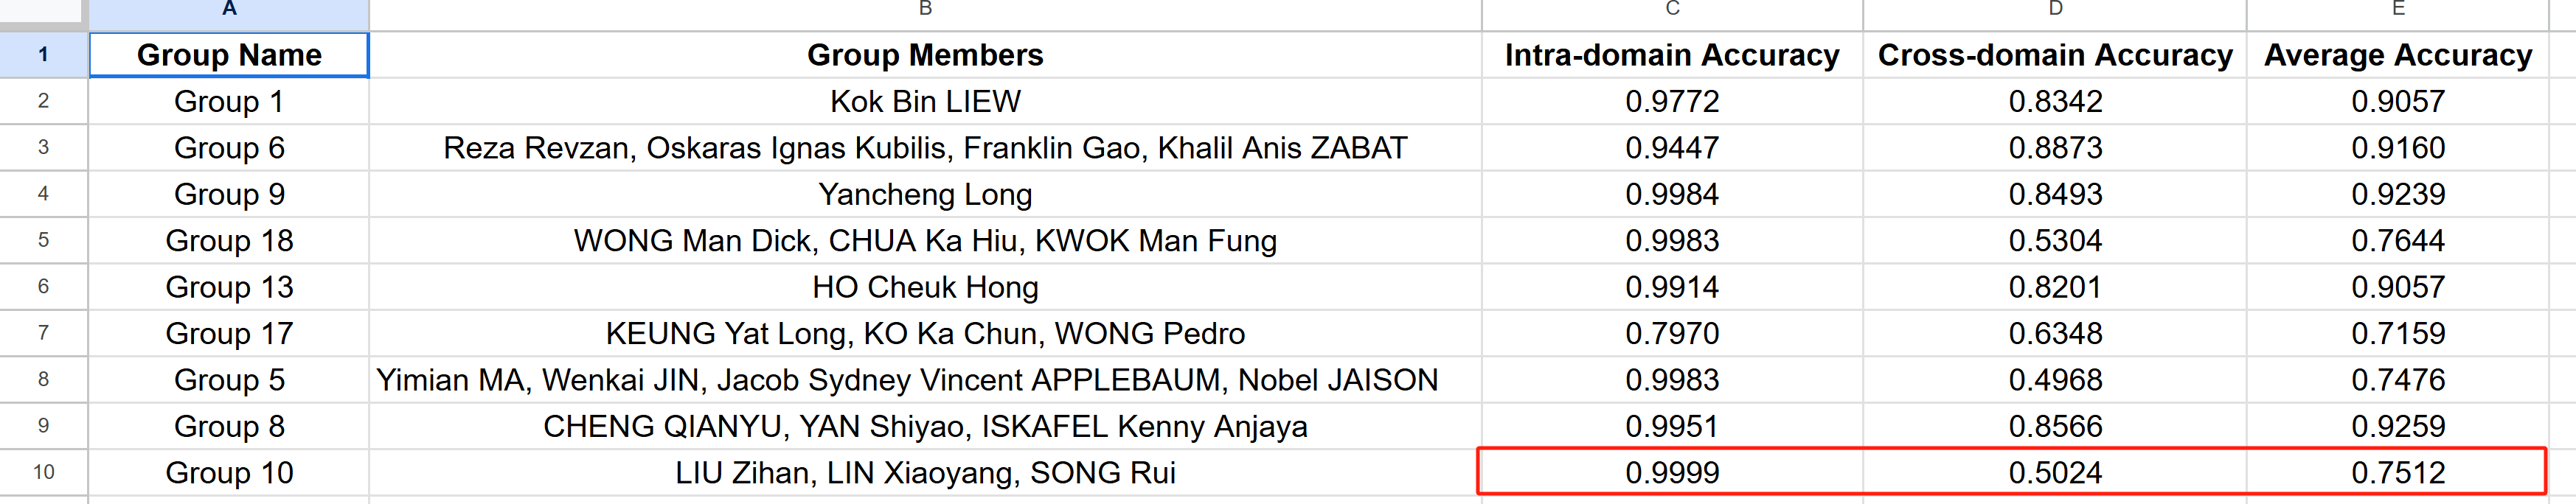

Models with attention mechanisms like Swin and ViT are overly complex, leading to overfitting and making them difficult to analyze through visualization and interpretation. Therefore, we decided to use ResNet for fine-tuning and inference in this project, as it allows for weight visualization and offers stronger interpretability of its weights.

### 4.2 The Second Test and Failure Analysis


We found a method called Grad-CAM, which outputs a heat map to show which part of the image the network pays more attention to for an input image. The output heat map is called Class Activation Mapping (CAM). Here we will not discuss the principles of CAM implementation in detail, but only consider its use. In this task, CAM can well explain the basis for the network's classification. If the hot spots in CAM are scattered or unreasonable, even if the network can output the correct result, it is likely that it is overfitting to certain features of the image generated by Stable Diffusion. Such a network may perform very poorly on cross-domain datasets.  

We found that Grad-CAM did not perform well on Transformer-based methods, which resulted in weak visualization and interpretability of Transformer, making optimization more difficult. In addition, Transformer's overly powerful fitting ability may lead to serious overfitting for such a simple task. Therefore, we finally decided to use ResNet. Grad-CAM can be implemented by: https://github.com/jacobgil/pytorch-grad-cam  

We found that for correctly predicted camera-captured images, the network’s CAM was almost blank, as shown in the figure. This means that the network does not need explicit evidence that an image was captured by a camera—in fact, humans cannot prove why an image must be captured by a camera.  
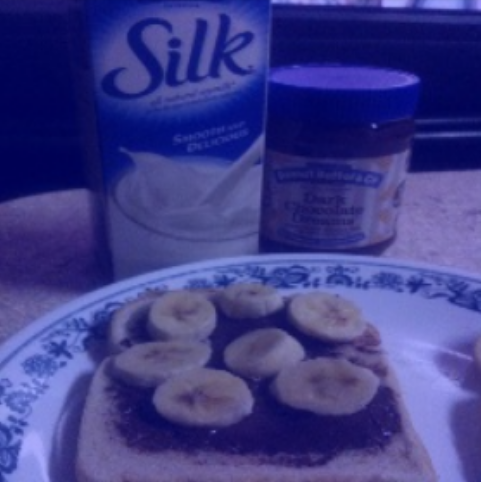  
For AI-generated images, CAM can well reflect the area of ​​network decision. We found that the CAM images generated by the previous training (2) are very easy to focus on the corners of the image, as shown in the figure below. We speculate that the reason for this situation is related to the previous study "Watch your Up-Convolution". It is possible that the up-convolution layer used by Stable Diffusion causes the frequency value of the image to change suddenly at the edge, or other network design defects cause the image corners to have special features. However, this feature is not universal, so it may not perform well on cross-source datasets.  
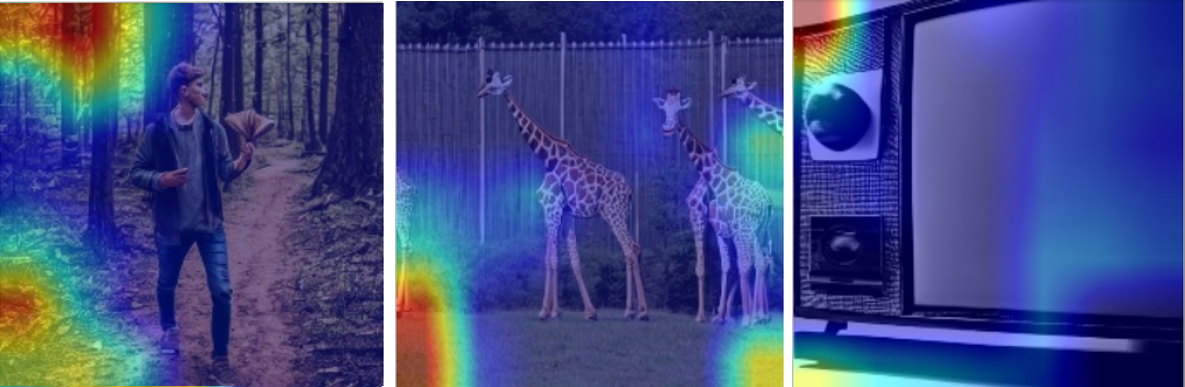

Therefore, we decided to use data augmentation to eliminate this common feature that exists in each image. The experimental setting is as (5). We used all mainstream data augmentation schemes, especially cropping, which we believe may have a significant effect on edge features. The training results are shown in the figure below. The CAM image proves the effectiveness of our method. Now the network is more focused on semantic features.  
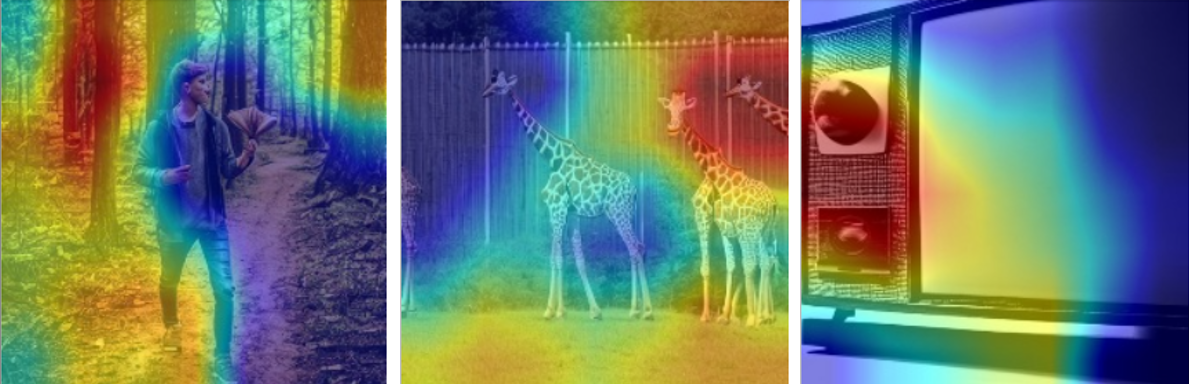

The result in second attempt is:  
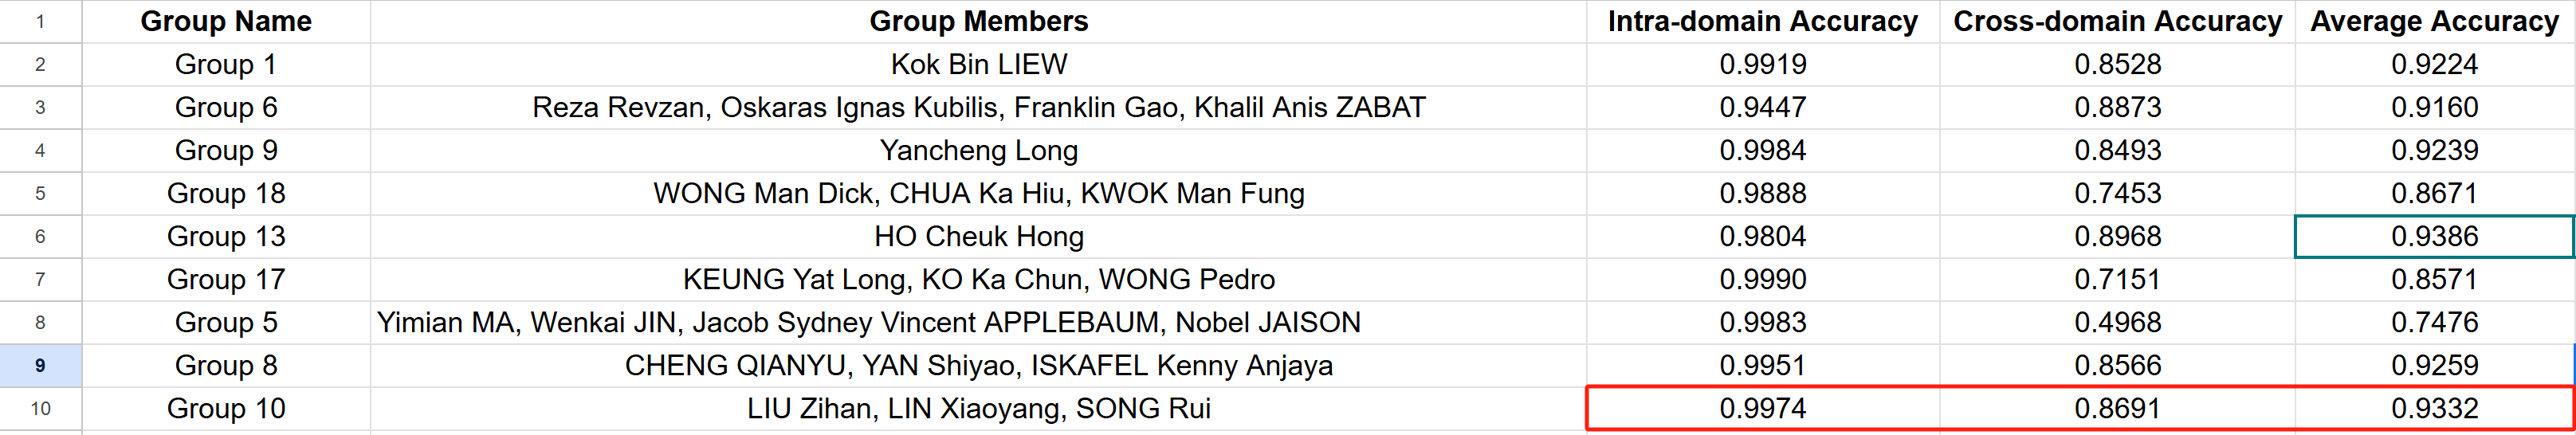

### 4.3 The Third Test - Focal Loss
Through the above analysis, we already know the basic principle of the network: for photos captured by the camera, the network does not look for specific features, but uses the method of elimination to make judgments. The network focuses on finding "traces generated by AI" rather than "traces captured by the camera." At the same time, we analyzed and found that the errors on the validation set are almost all AI pictures that are not detected, and there are very few camera photos that are identified as AI. Therefore, we believe that AI-generated pictures are a much more difficult class, and finding AI-generated pictures is the core of training. Therefore, for these two classes with uneven difficulty and focus, we decided to use the Focal loss function to balance them. The Focal loss function is usually used when the number of classes is uneven to prevent limited knowledge from leading to a lack of understanding of a certain class. In this task, the lack of understanding comes from the different difficulties of the two classes. We think this approach is relatively novel.

### Reference
Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. International Conference on Learning Representations (ICLR). https://arxiv.org/abs/2010.11929

Gildenblat, J., & Contributors. (2021). PyTorch library for CAM methods. GitHub. Retrieved December 8, 2024, from https://github.com/jacobgil/pytorch-grad-cam

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770–778. https://doi.org/10.1109/CVPR.2016.90

Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollar, P. (2017). Focal Loss for Dense Object Detection. Proceedings of the IEEE International Conference on Computer Vision (ICCV), 2980–2988. https://doi.org/10.1109/ICCV.2017.324

Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., ... & Guo, B. (2021). Swin Transformer: Hierarchical Vision Transformer using Shifted Windows. Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), 10012–10022. https://doi.org/10.1109/ICCV48922.2021.00989

Loshchilov, I., & Hutter, F. (2019). Decoupled weight decay regularization. International Conference on Learning Representations (ICLR). https://arxiv.org/abs/1711.05101

Odena, A., Dumoulin, V., & Olah, C. (2016). Deconvolution and Checkerboard Artifacts. Distill. https://doi.org/10.23915/distill.00003

Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017). Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization. Proceedings of the IEEE International Conference on Computer Vision (ICCV), 618–626. https://doi.org/10.1109/ICCV.2017.74